In [7]:
#load packages

from pyspark.sql import functions as F
from pyspark.sql.functions import levenshtein
from pyspark.sql import Window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import time
from datetime import date
from pyspark.sql.functions import concat_ws
import re

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, RegexTokenizer, CountVectorizer, StopWordsRemover, VectorAssembler
from pyspark.ml.feature import Word2Vec
from wordcloud import WordCloud

from pyspark.sql import SparkSession 
from pyspark.sql.types import StringType, FloatType


# 2. Debt servicing cost

In [8]:
# data cleaning function

expr = '[^A-Za-zÀ-ÿ0-9]+'

def datacleaning(selected_column, clean_column, inputdata):
    outputdata = (inputdata
        .withColumn(clean_column, F.lower(F.col(selected_column)))
        .withColumn(clean_column,
        F.regexp_replace(F.col(clean_column), expr, " ") )
        .withColumn(clean_column,
        F.regexp_replace(F.col(clean_column),"å","ao"))
        .withColumn(clean_column,
        F.regexp_replace(F.col(clean_column),"ä","ae"))
        .withColumn(clean_column,
        F.regexp_replace(F.col(clean_column),"ö","oe"))
        .withColumn(clean_column,
        F.regexp_replace(F.col(clean_column), '\\b(\d{2,})\\b', "") )
        .withColumn(clean_column,
        F.regexp_replace(F.col(clean_column), '\s+', " ") )
        .withColumn(clean_column, F.trim(F.col(clean_column)))
        )
    return outputdata

In [9]:
# wordcloudpic without removing stopwords
def wordcloudpic(inputdata, inputCol):
    regexTokenizer = RegexTokenizer(inputCol=inputCol, outputCol="words", minTokenLength=2, pattern=("\\W"))
    countTokens=F.udf(lambda words: len(words), IntegerType())
    regexTokenized = regexTokenizer.transform(inputdata)   
    words = (regexTokenized
         .select(F.posexplode('words').alias('l1','words'))
        .drop('l1').groupby('words')
         .agg(F.count('words').astype('float').alias('counts'))
         .orderBy(F.desc('counts')).toPandas())

    d={}
    for a, x in words.values:
        d[a]=int(x)
    
    wordcloud = WordCloud(
        width = 900,
        height = 500,
        background_color = 'white').generate_from_frequencies(frequencies=d)

    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return  

In [10]:
# wordcloudpic with removing stopwords

def wordcloudpic2(inputdata, inputCol):
    regexTokenizer = RegexTokenizer(inputCol=inputCol, outputCol="words", minTokenLength=2, pattern=("\\W"))
    countTokens=F.udf(lambda words: len(words), IntegerType())
    regexTokenized = regexTokenizer.transform(inputdata)
    stopwordsRemover=StopWordsRemover(inputCol="words",outputCol="filtered").setStopWords(add_words)
    stopwordscleaned=stopwordsRemover.transform(regexTokenized)
    
    filtered = (stopwordscleaned
         .select(F.posexplode('filtered').alias('l1','filtered'))
        .drop('l1').groupby('filtered')
         .agg(F.count('filtered').astype('float').alias('counts'))
         .orderBy(F.desc('counts')).toPandas())

    d={}
    for a, x in filtered.values:
        d[a]=int(x)
    
    wordcloud = WordCloud(
        width = 900,
        height = 500,
        background_color = 'white').generate_from_frequencies(frequencies=d)

    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return

In [11]:
firstelement=F.udf(lambda v:float(v[0]),FloatType())

## <font color='blue'>2.1 Data Selection</font>
Define loan transactions by provider and secaccountnum

when it is BG/PG payment, both secaccountnum and transactioninfo populated
- tob550 PG-BET. VIA INTERNET
- tob551 BG-BET. VIA INTERNET
- tob054 BANKGIRO

when it is autogiro payment, only transactioninfo populated
- tob486 AUTOGIRO

### <font color='blue'>2.1.1 List of all possible external financial institution names</font>

In [12]:
#load the loan provider list
banklist_pd = pd.read_csv("banklist_v4.csv", sep=';',) 

#put the list into a dataframe, so that it could be merged with the other pyspark dataframe
from pyspark.sql.types import *
schema = StructType([
StructField("banklist", StringType(), True)])
banklist_df = sqlContext.createDataFrame(banklist_pd, schema)
banklist_df.show(5)

banklist_clean=datacleaning(selected_column='banklist', clean_column='provider_cleaned', inputdata=banklist_df)
print(banklist_clean.count())
banklist_clean.show(5)

+-----------+
|   banklist|
+-----------+
| 247 CREDIT|
|   4FINANCE|
|AASA KREDIT|
|     ADVISA|
|   AFTERPAY|
+-----------+
only showing top 5 rows

164
+-----------+----------------+
|   banklist|provider_cleaned|
+-----------+----------------+
| 247 CREDIT|          credit|
|   4FINANCE|        4finance|
|AASA KREDIT|     aasa kredit|
|     ADVISA|          advisa|
|   AFTERPAY|        afterpay|
+-----------+----------------+
only showing top 5 rows



### <font color='blue'>2.1.2 External loan providers and their corresponding secaccountnum </font>
(external financial institutes to which customers do their loan payments)

In [13]:
# CC: need to add the process of how this list is generated

In [14]:
# CC: add by Chen
# select all the BG PG payments
bgpg=spark.sql('select secaccountnum, transactioninfo, count(*) as n, sum(-amount) as volumn \
from ddp_steer.p901cyo_trx_cust_201707_post12 where transtypecd in ("TOB550","TOB551","TOB054") \
group by secaccountnum, transactioninfo')

# clean the transactioninfo field
bgpg_clean=datacleaning(selected_column='transactioninfo', clean_column='transactioninfo_cleaned', inputdata=bgpg)
bgpg_clean.show(5)

+-------------+----------------+-----+-----------+-----------------------+
|secaccountnum| transactioninfo|    n|     volumn|transactioninfo_cleaned|
+-------------+----------------+-----+-----------+-----------------------+
|      1374974|    TELIA FINANS|   45|   21294.04|           telia finans|
|     49071020|ST1/NORDEA FINAN|43966|60991355.20|       st1 nordea finan|
|      9001835|Insamlingsstifte|  243|   61525.00|       insamlingsstifte|
|     50364785|   Västerås Stad|11454|12303138.00|        vaesteraos stad|
|      8690075|SVD/PayEx Sverig|12040| 5959871.37|       svd payex sverig|
+-------------+----------------+-----+-----------+-----------------------+
only showing top 5 rows



In [15]:
# CC: add by Chen
# import a list of the financial services companies and use that to search in the cleaned BG PG payments file
#banklist=banklist_pd['banklist'].values.tolist()
#banklist=[str(r) for r in banklist]
banklist=banklist_clean.select('provider_cleaned').rdd.flatMap(lambda x: x).collect()
banklist=[str(r) for r in banklist]
banklist

['credit',
 '4finance',
 'aasa kredit',
 'advisa',
 'afterpay',
 'agco finans',
 'akova finans',
 'alektum',
 'ambrion finans',
 'american express',
 'ansvar finans',
 'arvato finance',
 'ats finans',
 'avantia finans',
 'avanza',
 'avida',
 'balanzia',
 'bigbank',
 'bisnode kredit',
 'bluestep',
 'bmw financial',
 'boa re paypal in',
 'brixo',
 'brocc ab',
 'bynk',
 'captum group',
 'carmatic finans',
 'cash2you',
 'cashbuddy',
 'centrala studies',
 'citi',
 'city finans',
 'collector',
 'colligent',
 'corrigo finans',
 'credento',
 'credex',
 'credigo',
 'credway',
 'danske',
 'diners club',
 'dnb',
 'dreams',
 'easy credit',
 'easycredit',
 'elcf',
 'entercard',
 'eurocard',
 'eurocredit',
 'eurokredit',
 'euroloan',
 'extra kredit',
 'ferratum',
 'finans',
 'finans2',
 'finansia',
 'finanspro',
 'folkefinans',
 'ford',
 'forex',
 'fortnox finans',
 'frogtail',
 'ge money',
 'gjensidige',
 'goodcash',
 'gothia',
 'handelsbanken',
 'hoist kredit',
 'ica',
 'if skadefoersaekri',
 'ika

In [17]:
# CC: add by Chen
# select all the records in which the transaction information contains the key word from banklist_v4, 
# summarize the file based on secaccountnum and transactioninfo
# select the top 2 popular transactioninfo for each secaccountnum
# match the top 2 popular transactioninfo with the banklist_v4 key words again 
# find the ones that contain the key words from banklist_v4
trx_window = Window.partitionBy("secaccountnum").orderBy(F.desc("n"))
all_name=bgpg_clean\
.withColumn('secaccountnum_fix',F.col('secaccountnum').cast('int'))\
.drop('secaccountnum')\
.withColumnRenamed('secaccountnum_fix','secaccountnum')\
.filter((F.col('transactioninfo_cleaned').rlike('(^|\s)(' + '|'.join(banklist) + ')(\s|$|\s\w+)')))\
.select('secaccountnum').dropDuplicates()\
.join(bgpg_clean,['secaccountnum'],'inner')\
.orderBy(F.col('secaccountnum'), F.desc('n')).filter(F.col('n')>10)\
.withColumn("rank", F.dense_rank().over(trx_window)).filter(F.col('rank')<=2)\
.filter((F.col('transactioninfo_cleaned').rlike('(^|\s)(' + '|'.join(banklist) + ')(\s|$|\s\w+)')))
all_name.show(5)
#.filter((F.col('transactioninfo_cleaned').rlike('(^|\s)(' + '|'.join(banklist) + ')(\s|$|\w+|\s\w+)')))\

+-------------+---------------+-----+------------+-----------------------+----+
|secaccountnum|transactioninfo|    n|      volumn|transactioninfo_cleaned|rank|
+-------------+---------------+-----+------------+-----------------------+----+
|      5902689|PayEx/Storegate| 2021|   473937.47|        payex storegate|   1|
|     50950781| ICA SVERIGE AB|   12|    37735.52|         ica sverige ab|   1|
|     51772077|SEVENDAY FINANS|12805|119521760.56|        sevenday finans|   1|
|     51772077|       sevenday|  324|  3223902.30|               sevenday|   2|
|     52138252|           bynk|   12|   391641.00|                   bynk|   2|
+-------------+---------------+-----+------------+-----------------------+----+
only showing top 5 rows



In [18]:
# CC: test
start = time.time()
print(all_name.cache().count())
end = time.time()
print(end - start)

1552
212.550057173


In [19]:
# check
all_name.filter(F.col('transactioninfo').rlike('247 Credit')).show()
all_name.filter(F.col('transactioninfo_cleaned').rlike('credigo')).show()
all_name.filter(F.col('secaccountnum')==3626181).show()

+-------------+----------------+---+---------+-----------------------+----+
|secaccountnum| transactioninfo|  n|   volumn|transactioninfo_cleaned|rank|
+-------------+----------------+---+---------+-----------------------+----+
|      6186779|247 Credit Sveri|150|190684.00|           credit sveri|   1|
+-------------+----------------+---+---------+-----------------------+----+

+-------------+----------------+-----+-----------+-----------------------+----+
|secaccountnum| transactioninfo|    n|     volumn|transactioninfo_cleaned|rank|
+-------------+----------------+-----+-----------+-----------------------+----+
|      5183264|Credigo/Avida Fi|  379| 1868699.24|       credigo avida fi|   1|
|      1822980|Credigo/Avida Fi|22575|52173550.39|       credigo avida fi|   1|
|      1822980|         Credigo|  640| 1765042.97|                credigo|   2|
+-------------+----------------+-----+-----------+-----------------------+----+

+-------------+----------------+------+------------+------

In [20]:
# CC: add by Chen
# create a list of secaccountnum and the relevant transactioninfo
secaccnr_list=all_name.select('secaccountnum','transactioninfo','transactioninfo_cleaned','n','volumn')\
.orderBy(F.col('secaccountnum'),F.desc('n'),F.desc('volumn'))\
.withColumn('secaccountnum_fix',F.col('secaccountnum').cast('int'))\
.drop('secaccountnum')\
.withColumnRenamed('secaccountnum_fix','secaccountnum')\
.dropDuplicates(['secaccountnum'])
secaccnr_list.show(5)
# -------------------------------------------------------------------------------------------------
# CC: add by Chen
# count the volumn and the amount under the same secaccountnum
amount=all_name.select('secaccountnum','transactioninfo','transactioninfo_cleaned','n','volumn')\
.groupBy('secaccountnum').agg(F.sum('n').alias('n'),F.sum('volumn').alias('volumn'))
amount.show(5)
# -------------------------------------------------------------------------------------------------
# CC: add by Chen
# put the secaccountnum list and the volumn and amount together.
exhausted_list=secaccnr_list.select('secaccountnum','transactioninfo','transactioninfo_cleaned')\
.join(amount,['secaccountnum'],'left')
# check the result
exhausted_list.filter(F.col('secaccountnum')==41585027).show(5)

+----------------+-----------------------+-----+------------+-------------+
| transactioninfo|transactioninfo_cleaned|    n|      volumn|secaccountnum|
+----------------+-----------------------+-----+------------+-------------+
| PayEx/Storegate|        payex storegate| 2021|   473937.47|      5902689|
|  ICA SVERIGE AB|         ica sverige ab|   12|    37735.52|     50950781|
| SEVENDAY FINANS|        sevenday finans|12805|119521760.56|     51772077|
|            Bynk|                   bynk|   12|   436625.00|     52138252|
|SWEDBANK AB (PUB|        swedbank ab pub|  195|   557474.00|     53798245|
+----------------+-----------------------+-----+------------+-------------+
only showing top 5 rows

+-------------+-----+------------+
|secaccountnum|    n|      volumn|
+-------------+-----+------------+
|      5902689| 2021|   473937.47|
|     50950781|   12|    37735.52|
|     51772077|13129|122745662.86|
|     52138252|   24|   828266.00|
|     53798245|  195|   557474.00|
+----------

In [21]:
updatelist=exhausted_list\
.withColumn(
        'match', 
        F.regexp_extract('transactioninfo_cleaned', '(?=^|\s)(' + '|'.join(banklist) + ')(?=\s|$|\s\w+)', 1))\
.withColumn('match_len', F.length(F.col('match')))\
.withColumn('category', F.when(F.upper(F.col('transactioninfo_cleaned')).rlike('BOLAON')|F.upper(F.col('transactioninfo_cleaned')).rlike('FASTIGH')|\
                            F.upper(F.col('transactioninfo_cleaned')).rlike('BOSTAD')|F.upper(F.col('transactioninfo_cleaned')).rlike('HYPOTEK'),'mortgage')\
                      .when(F.upper(F.col('transactioninfo_cleaned')).rlike('KORT')|F.upper(F.col('transactioninfo_cleaned')).rlike('CARD')|\
                            F.upper(F.col('transactioninfo_cleaned')).rlike('VISA')|F.upper(F.col('transactioninfo_cleaned')).rlike('MASTER'),'card')\
                      .when(F.upper(F.col('transactioninfo_cleaned')).rlike('(?=^|\s)SWEDBANK(?=\s|$|[a-z])')| \
                            F.upper(F.col('transactioninfo_cleaned')).rlike('ENTERCARD')|\
                            F.upper(F.col('transactioninfo_cleaned')).rlike('PAYEX'),'Swedbank')\
                      .when(F.upper(F.col('transactioninfo_cleaned')).rlike('FOERSAEKRING')|F.upper(F.col('transactioninfo_cleaned')).rlike('PENSION')|\
                                F.upper(F.col('transactioninfo_cleaned')).rlike('LIV')|F.upper(F.col('transactioninfo_cleaned')).rlike('FOLKSAM')|F.upper(F.col('transactioninfo_cleaned')).rlike('trygg'),'insurance')\
                      .when(F.upper(F.col('transactioninfo_cleaned')).rlike('OKQ8')|F.upper(F.col('transactioninfo_cleaned')).rlike('PREEM')|\
                                  F.upper(F.col('transactioninfo_cleaned')).rlike('CIRCLE')|F.upper(F.col('transactioninfo_cleaned')).rlike('STATOIL')|\
                                  F.upper(F.col('transactioninfo_cleaned')).rlike('EQUINOR'),'petrostation')\
                      .when(F.upper(F.col('transactioninfo_cleaned')).rlike('TELIASONERA')|F.upper(F.col('transactioninfo_cleaned')).rlike('TELENOR')|\
                           F.upper(F.col('transactioninfo_cleaned')).rlike('TELE2')|F.upper(F.col('transactioninfo_cleaned')).rlike('HI3G')|\
                            F.upper(F.col('transactioninfo_cleaned')).rlike('TELIA MOBIL')|F.upper(F.col('transactioninfo_cleaned')).rlike('COMVIQ')|\
                            F.upper(F.col('transactioninfo_cleaned')).rlike('BREDBAND')|F.upper(F.col('transactioninfo_cleaned')).rlike('CANAL DIGITAL')
                            ,'mobil')\
                      .when(F.upper(F.col('transactioninfo_cleaned')).rlike('RADIOTJAENST')|F.upper(F.col('transactioninfo_cleaned')).rlike('CENTRALA STUDIES')|\
                           F.upper(F.col('transactioninfo_cleaned')).rlike('SKATTEVERKET')|F.upper(F.col('transactioninfo_cleaned')).rlike('TRANSPORTSTYRELS')|\
                           F.upper(F.col('transactioninfo_cleaned')).rlike('INTELEON AB')|F.upper(F.col('transactioninfo_cleaned')).rlike('ARBETSLOESHETSKAS') ,'government')\
                      .when(F.upper(F.col('transactioninfo_cleaned')).rlike('VATTENFALL')|F.upper(F.col('transactioninfo_cleaned')).rlike('ENERGI')|\
                           F.upper(F.col('transactioninfo_cleaned')).rlike('FORTUM'),'electricity')\
                            .otherwise('other'))
print(updatelist.count())
#--------------------------------------------------------------------------------------------------------------------------------
#output to csv
pandaoutput = updatelist.toPandas()
pandaoutput.to_csv(os.path.join('~/repos', 'provider_v10' + '.csv'), encoding='utf-8')

1250


In [22]:
# CC: this exhausted_list is the base file of loanprovider. maybe need to add process in between to reach the loan provider list
# need to manually go through the file to and saved loanprovider_v10 and loanprovider_v10_short. first file contains all the info
# second file contains only the three variable.
#load the loan provider list
loanprovider_pd = pd.read_csv("loanprovider_v10_short.csv", sep=';',) 

#put the list into a dataframe, so that it could be merged with the other pyspark dataframe
from pyspark.sql.types import *
schema = StructType([
StructField("category", StringType(), True),
StructField("provider", StringType(), True),       
StructField("secaccountnum", StringType(), True)])
loanprovider = sqlContext.createDataFrame(loanprovider_pd, schema)
loanprovider_pd
#-------------------------------------------------------------------------------------------------------------------
loanprovider_clean=datacleaning(selected_column='provider', clean_column='provider_cleaned', inputdata=loanprovider)
loanprovider_clean.show(5, False)

+------------+-------------------+-------------+-------------------+
|category    |provider           |secaccountnum|provider_cleaned   |
+------------+-------------------+-------------+-------------------+
|NaN         |payex              |5902689      |payex              |
|consumerloan|sevenday           |51772077     |sevenday           |
|smsloan     |bynk               |52138252     |bynk               |
|NaN         |swedbank           |53798245     |swedbank           |
|mortgage    |laensfoersaekringar|59547604     |laensfoersaekringar|
+------------+-------------------+-------------+-------------------+
only showing top 5 rows



In [23]:
# CC: the aim of the bgpg_loanproviders dataset is to identify relevant secaccountnum, 
# CC: then we need to merge bgpg_loanprovider dataset with the full debt_bgpg_clean file to tag all the relevant secaccoutnum
# CC: as paying to financial institutions, therefore all the transactioninfo that are associated with the secaccountnum will 
# CC: helps us to form a dictionary of relevant word to identify a payment to a financial institution.

### <font color='blue'> 2.1.3 take a sample of autogiro and bgpg transaction dataframes </font>

In [24]:
# CC: in this context, training data is pgbg payment data and testing data is auto giro data, so this part of the code is 
# CC: not about training and testing data
# testdata, used for training and testing
raw_data=str('ddp_steer.p901cyo_trx_cust_201707_pre12')

# compare the test results to this data
raw_data_result_comparison=str('ddp_steer.p901cyo_trx_cust_201707_post12')
#----------------------------------------------------------------------------------
# debt definitions
DEBT_BGPG=(str("TOB550"),str("TOB551"),str("TOB054"))
Month=(str('201704'),str('201705'),str('201706'))
#----------------------------------------------------------------------------------
# secaccountnumber, transactiontype, number of and amount 
# for all transactions of each transaction type to an external financial institute
debt_pgbg=spark.sql('select secaccountnum, transactioninfo, count(*) as nr_of_trx, -sum(amount) as vol \
                    from %s where transtypecd in %s \
                    and transactionmonth in %s group by secaccountnum, transactioninfo' \
                    %(raw_data, DEBT_BGPG, Month))\
            .join(loanprovider_clean, ['secaccountnum'],'left')\
            .orderBy(F.desc('nr_of_trx'))\
            .withColumn("ID", F.monotonically_increasing_id())
debt_pgbg.show(5)
#-----------------------------------------------------------------------------------
# autogiro payments
debt_autogiro = spark.sql('select transactioninfo, count(*) as nr_of_trx, -sum(amount) as vol \
                        from %s where transtypecd="TOB486" and \
                        transactionmonth in %s group by transactioninfo' %(raw_data,  Month))\
            .orderBy(F.desc('nr_of_trx'))\
            .withColumn("ID", F.monotonically_increasing_id())
debt_autogiro.show(5)

+-------------+----------------+---------+------------+----------+---------+----------------+---+
|secaccountnum| transactioninfo|nr_of_trx|         vol|  category| provider|provider_cleaned| ID|
+-------------+----------------+---------+------------+----------+---------+----------------+---+
|     41585027|KLARNA AB /NORDE|   526300|369275848.28|   invoice|   klarna|          klarna|  0|
|      8200040|TELIASONERA SVER|   383497|217271241.43|      null|     null|            null|  1|
|     51225860|ENTERCARD SVERIG|   239163|725503638.68|creditcard|entercard|       entercard|  2|
|     53311338| Telenor Sverige|   191901|128281567.53|      null|     null|            null|  3|
|      9366006|Tele2 - Mobila t|   164884| 72841935.53|      null|     null|            null|  4|
+-------------+----------------+---------+------------+----------+---------+----------------+---+
only showing top 5 rows

+---------------+---------+------------+---+
|transactioninfo|nr_of_trx|         vol| ID|
+--

#### <font color='blue'>Bag of Words visualization before data cleaning</font>
Used for wiki and ppt presentation

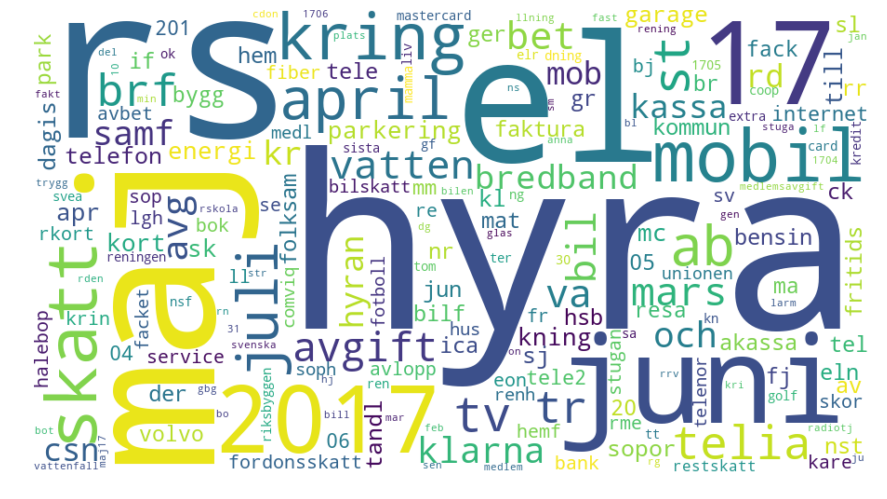

In [25]:
wordcloudpic(inputdata=debt_pgbg, inputCol="transactioninfo")

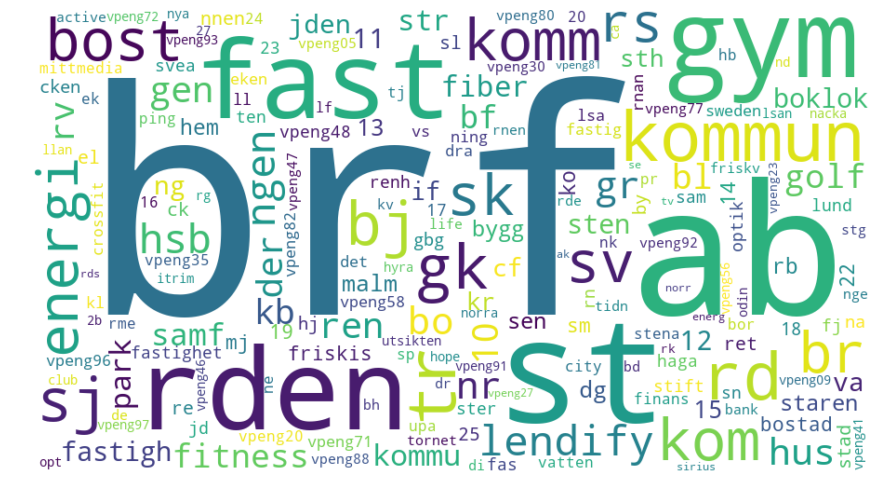

In [26]:
wordcloudpic(inputdata=debt_autogiro, inputCol="transactioninfo")

#### <font color='blue'>Clean autogiro and pgbg datasets from special characters</font>
- debt_pgbg = BG/PG, known counterparties
- debt_autogiro = Autogiro, unknown counterparties

In [27]:
debt_pgbg_clean=datacleaning(selected_column='transactioninfo', clean_column='transactioninfo_cleaned', inputdata=debt_pgbg)
debt_pgbg_clean.show(5)
#----------------------------------------------------------------------------------------------
debt_autogiro_clean=datacleaning(selected_column='transactioninfo', clean_column='transactioninfo_cleaned', inputdata=debt_autogiro)\
        .filter(~F.col('transactioninfo').rlike('\d{5,}'))\
        .filter(~F.col('transactioninfo').like('SvSP000%'))\
        .filter(~F.col('transactioninfo').rlike('VPENG'))
debt_autogiro_clean.show(5)

+-------------+----------------+---------+------------+----------+---------+----------------+---+-----------------------+
|secaccountnum| transactioninfo|nr_of_trx|         vol|  category| provider|provider_cleaned| ID|transactioninfo_cleaned|
+-------------+----------------+---------+------------+----------+---------+----------------+---+-----------------------+
|     41585027|KLARNA AB /NORDE|   526300|369275848.28|   invoice|   klarna|          klarna|  0|        klarna ab norde|
|      8200040|TELIASONERA SVER|   383497|217271241.43|      null|     null|            null|  1|       teliasonera sver|
|     51225860|ENTERCARD SVERIG|   239163|725503638.68|creditcard|entercard|       entercard|  2|       entercard sverig|
|     53311338| Telenor Sverige|   191901|128281567.53|      null|     null|            null|  3|        telenor sverige|
|      9366006|Tele2 - Mobila t|   164884| 72841935.53|      null|     null|            null|  4|         tele2 mobila t|
+-------------+---------

#### <font color='blue'> Cache data sets</font>

In [28]:
start = time.time()
print(debt_pgbg_clean.cache().count())
end = time.time()
print(end - start)
debt_pgbg_clean.is_cached

2286420
174.714997053


True

In [29]:
start = time.time()
print(debt_autogiro_clean.cache().count())
end = time.time()
print(end - start)
debt_autogiro_clean.is_cached

11942
142.76816988


True

#### <font color='blue'>Bag of Words visualization after data cleaning</font>
For wiki and ppt presentation

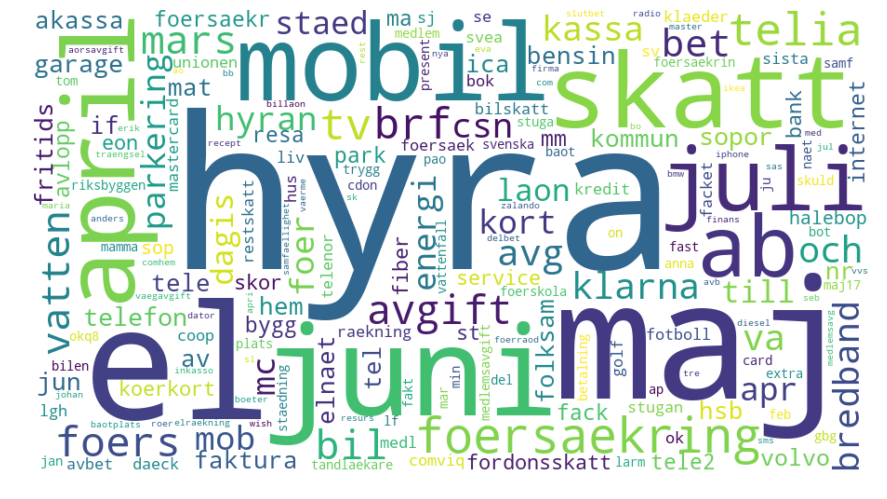

In [25]:
wordcloudpic(inputdata=debt_pgbg_clean, inputCol="transactioninfo_cleaned")

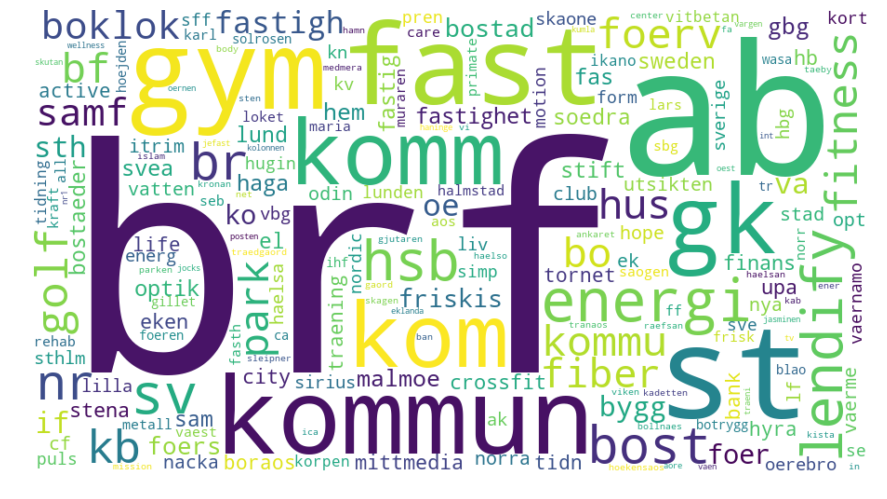

In [26]:
wordcloudpic(inputdata=debt_autogiro_clean, inputCol="transactioninfo_cleaned")

## <font color='blue'>2.2 Data Exploration</font>

### <font color='blue'>2.2.1 Stopword (or token) Analysis</font>
We start by trying to identify words that uniquely describe the companies that the customers pay money to, i.e. the potential loan providers. This is the same as identifying so-called stop words, i.e. words that can be disregarded since they are too generic/undescriptive. 

Stop words
- Single letters such as A, B, V etc

Remain
- Two-letter words such as LF or IF

We use word frequency, trx frequency and trx amount % as limits for when tokens/names are relevant

#### <font color='blue'>BGPG token frequencies (of the pre-processed data)</font>

In [28]:
# CC: the file that you need to transform is not bgpg_loanproviders. It should be debt_pgbg_clean.
# token frequency
regexTokenizer = RegexTokenizer(inputCol="transactioninfo_cleaned", outputCol="words", minTokenLength=2, pattern=("\\W"))
# CC: trxinfo_tokens = (regexTokenizer.transform(bgpg_loanproviders).dropDuplicates())
trxinfo_tokens = (regexTokenizer.transform(debt_pgbg_clean).dropDuplicates())
# --------------------------------------------------------
# frequency of trx
trx_sum = trxinfo_tokens.agg(F.sum('nr_of_trx')).collect()[0][0] 

# trx volume amount analysis
vol_sum = trxinfo_tokens.agg(F.sum('vol')).collect()[0][0] 
# CC: calculate frequency and volumn after dropDuplicates will lead to underestimate the frequency and volumn
# CC: test remove duplicate effect, seems that no impact
# CC: print(trxinfo_tokens.count(),trx_sum,vol_sum)
# CC: print(regexTokenizer.transform(debt_pgbg_clean).count(), 
# CC:      regexTokenizer.transform(debt_pgbg_clean).agg(F.sum('nr_of_trx')).collect()[0][0],
# CC:     regexTokenizer.transform(debt_pgbg_clean).agg(F.sum('vol')).collect()[0][0])
# --------------------------------------------------------
# frequency of words
sel_col = ['transactioninfo','transactioninfo_cleaned','nr_of_trx','ID','vol','words','tokens']
trxinfo_tokens = trxinfo_tokens.withColumn('tokens',F.explode('words')).select(sel_col)
#----------------------------------------------------------------------------------------------
token_count = (trxinfo_tokens.select('tokens').dropDuplicates().count())  #452839

trxinfo_tokensfreq = (trxinfo_tokens.groupBy("tokens")
             .agg(F.count('ID').alias('nr_of_token_occurrences'))
             .sort(F.desc('nr_of_token_occurrences')) 
              .withColumn('token_freq', 100 * F.col('nr_of_token_occurrences')/token_count )
                     )

sel_col = ['tokens','transactioninfo','token_freq']
trxinfo_tokensfreq = trxinfo_tokensfreq.join(trxinfo_tokens,['tokens'],'inner').select(sel_col)
# autogiro_tokensfreq.show(5, False)

# --------------------------------------------------------
# frequency of trx
trxinfo_trxfreq = (trxinfo_tokens.groupBy("tokens")
             .agg(F.sum('nr_of_trx').alias('nr_of_trx'))
             .sort(F.desc('nr_of_trx')) 
              .withColumn('freq_nr_of_trx', 100 * F.col('nr_of_trx')/trx_sum )
)

# show trx frequency for each token and transactioninfo name
sel_col = ['tokens','transactioninfo','freq_nr_of_trx']# ,'transactioninfo','transactioninfo_cleaned'

trxinfo_trxfreq = (trxinfo_tokens.join(trxinfo_trxfreq,['tokens'],'inner')
    .select(sel_col)
    .sort(F.desc('freq_nr_of_trx'))
   # .filter((F.col('freq_nr_of_trx') > 0.03) & (F.length(F.col('tokens')) == 2))
    .dropDuplicates()
)
# autogiro_trxfreq.show(2, False)

# --------------------------------------------------------
# trx volume amount analysis
#sel_col = ['transactioninfo','transactioninfo_cleaned','nr_of_trx','ID','vol','words','tokens']
trxinfo_volfreq = (trxinfo_tokens.groupBy("tokens")
             .agg(F.sum('vol').alias('vol'))
             .sort(F.desc('vol')) 
              .withColumn('volfreq', 100 * F.col('vol')/vol_sum )
                     )

sel_col = ['tokens','transactioninfo','volfreq']

trxinfo_volfreq = (trxinfo_tokens.join(trxinfo_volfreq,['tokens'],'inner')
.select(sel_col)
.sort(F.desc('volfreq'))
#.filter((F.col('volfreq') > 0.03) & (F.length(F.col('tokens')) == 2)).dropDuplicates()
)

# autogiro_volfreq.show(2, False)

# join on token
trxinfo_tokens_analysis = (trxinfo_tokensfreq.select('tokens', 'token_freq').dropDuplicates()
                            .join(trxinfo_trxfreq.select('tokens', 'freq_nr_of_trx').dropDuplicates(), ['tokens'], 'inner')
                            .join(trxinfo_volfreq.select('tokens', 'volfreq').dropDuplicates(), ['tokens'], 'inner')
                           )
#(trxinfo_tokens_analysis
#.sort(F.desc('token_freq'))
#.show(5, False))

In [29]:
# CC: go through the high frequency token, identify tokens that has no actual meaning in explaining the company type
# CC: e.g. maj, juni, april, juli, ab, mars, apr, faktura, jun, feb, jan, mar, maj17, jul, apri, aug, may, juni17, august, mar17, 
# CC: april17, apr17, june, augusti, jun17, sept, juli17, maj2017, mars17, september, februari, juni2017, july, april2017,
# CC: sverig, sveri 
# CC: ocr, faktu, faktnr, betala, delbetalning, inbetalning, avbetalning, sthlm, svensk, stockholm, sweden, stockholms. these are obvious stop words.
(trxinfo_tokens.groupBy("tokens")
             .agg(F.count('ID').alias('nr_of_token_occurrences'))
             .sort(F.desc('nr_of_token_occurrences')) 
              .withColumn('token_freq', 100 * F.col('nr_of_token_occurrences')/token_count )
                     ).filter(F.col('token_freq')<0.033).orderBy(F.desc('token_freq')).show(50)

+------------+-----------------------+--------------------+
|      tokens|nr_of_token_occurrences|          token_freq|
+------------+-----------------------+--------------------+
|     revisor|                    149| 0.03291595606493059|
|        prag|                    149| 0.03291595606493059|
|      seguro|                    149| 0.03291595606493059|
|    autoplan|                    149| 0.03291595606493059|
|       diana|                    149| 0.03291595606493059|
|    kylskaop|                    149| 0.03291595606493059|
|      jossan|                    149| 0.03291595606493059|
|      nummer|                    149| 0.03291595606493059|
|      maerta|                    149| 0.03291595606493059|
|   inredning|                    149| 0.03291595606493059|
|      filmer|                    149| 0.03291595606493059|
|    matkonto|                    149| 0.03291595606493059|
|        gotl|                    149| 0.03291595606493059|
|       raett|                    149| 0

In [31]:
(trxinfo_tokens.groupBy("tokens")
             .agg(F.count('ID').alias('nr_of_token_occurrences'))
             .sort(F.desc('nr_of_token_occurrences')) 
              .withColumn('token_freq', 100 * F.col('nr_of_token_occurrences')/token_count )
                     ).filter(F.length('tokens')==3).orderBy(F.desc('token_freq')).show(50)

+------+-----------------------+-------------------+
|tokens|nr_of_token_occurrences|         token_freq|
+------+-----------------------+-------------------+
|   maj|                  60381| 13.338915054742106|
|   brf|                  16256| 3.5911528979296086|
|   bil|                  14044| 3.1024945434623166|
|   bet|                  12628| 2.7896825046170703|
|   avg|                  12097|  2.672377990050103|
|   och|                  10941|  2.417003189975876|
|   csn|                   9264| 2.0465329999027984|
|   mob|                   9006| 1.9895375860454019|
|   apr|                   8601|  1.900068041036698|
|   hem|                   6364| 1.4058868751491158|
|   jun|                   6204| 1.3705408820592575|
|   mat|                   5966| 1.3179637173380934|
|   hsb|                   5814|  1.284385023902728|
|   ica|                   5743| 1.2687002394691032|
|   tel|                   5648| 1.2477135560719999|
|   eon|                   4273| 0.94395892795

In [35]:
# CC: for the token that we can't judge by the token itself, we need to put it into a context to decide if we need to remove it.
# CC: remove sv, pa, ql, tr, fi, de, ek, va, se, ma, as, ce, nr, ko, kb, mm, hb, av, oc, no, sk 
# CC: would be good to have some swedish speakers to review this
trxinfo_trxfreq.filter((~F.col('tokens').isin('ab','ok','q8','on','ki','el','sv','tv','pa','ql','tr','fi','de','ek','if','va', \
                                             'b2','ag','mc','gs','ge','st','hm','se','ka','ma','as','gb','sj','ce','nr','tj', \
                                             'fa','ij','ba','er','la','ko','kb', 'mm','lf','sg','hb','sl','br','av','oc','gr', \
                                             'no','bo','dn','sk')) \
                       &(F.length('tokens')<=2)).orderBy(F.desc('freq_nr_of_trx')).show(50)

+------+----------------+--------------------+
|tokens| transactioninfo|      freq_nr_of_trx|
+------+----------------+--------------------+
|    sk|E SPETZ firma SK|0.027451611629896303|
|    sk|           SK DC|0.027451611629896303|
|    sk|       Intrum sk|0.027451611629896303|
|    sk|Int. Engelska Sk|0.027451611629896303|
|    sk|Project Coast Sk|0.027451611629896303|
|    sk|HOBURGS HEM & SK|0.027451611629896303|
|    sk|              sk|0.027451611629896303|
|    sk|      Barkarö SK|0.027451611629896303|
|    sk|      SUNNANÅ SK|0.027451611629896303|
|    sk|ANEBY SK HUVUDKA|0.027451611629896303|
|    sk|ELEKTROTJÄNST SK|0.027451611629896303|
|    sk|        tele2 sk|0.027451611629896303|
|    sk|Alfred Astrid sk|0.027451611629896303|
|    sk|LIF VFF SK Samar|0.027451611629896303|
|    sk|      sk husvagn|0.027451611629896303|
|    sk|GÄVLE KOMMUNS SK|0.027451611629896303|
|    sk|       HOLSBY SK|0.027451611629896303|
|    sk|Livförsäkring Sk|0.027451611629896303|
|    sk|återb

#### <font color='blue'>Autogiro token frequencies</font>

In [38]:
# CC: should this follow the same procedure as bgpg?
# token frequency
regexTokenizer = RegexTokenizer(inputCol="transactioninfo_cleaned", outputCol="words", minTokenLength=2, pattern=("\\W"))
autogiro_tokens = (regexTokenizer.transform(debt_autogiro_clean).dropDuplicates())
# --------------------------------------------------------
# frequency of trx
trx_sum = autogiro_tokens.agg(F.sum('nr_of_trx')).collect()[0][0] # 14198059

# trx volume amount analysis
vol_sum = autogiro_tokens.agg(F.sum('vol')).collect()[0][0] # 8409678479.81
# --------------------------------------------------------
# frequency of words
sel_col = ['transactioninfo','transactioninfo_cleaned','nr_of_trx','ID','vol','words','tokens']
autogiro_tokens = autogiro_tokens.withColumn('tokens',F.explode('words')).select(sel_col)
#-----------------------------------------------------------------------------------------
token_count = (autogiro_tokens.select('tokens').dropDuplicates().count()) # 10722

autogiro_tokensfreq = (autogiro_tokens.groupBy("tokens")
             .agg(F.count('ID').alias('nr_of_token_occurrences'))
             .sort(F.desc('nr_of_token_occurrences')) 
              .withColumn('token_freq', 100 * F.col('nr_of_token_occurrences')/token_count )
                     )

sel_col = ['tokens','transactioninfo','token_freq']
autogiro_tokensfreq = autogiro_tokensfreq.join(autogiro_tokens,['tokens'],'inner').select(sel_col)
# autogiro_tokensfreq.show(5, False)

# --------------------------------------------------------
# frequency of trx
autogiro_trxfreq = (autogiro_tokens.groupBy("tokens")
             .agg(F.sum('nr_of_trx').alias('nr_of_trx'))
             .sort(F.desc('nr_of_trx')) 
              .withColumn('freq_nr_of_trx', 100 * F.col('nr_of_trx')/trx_sum )
)

# show trx frequency for each token and transactioninfo name
sel_col = ['tokens','transactioninfo','freq_nr_of_trx']# ,'transactioninfo','transactioninfo_cleaned'

autogiro_trxfreq = (autogiro_tokens.join(autogiro_trxfreq,['tokens'],'inner')
    .select(sel_col)
    .sort(F.desc('freq_nr_of_trx'))
    #.filter((F.col('freq_nr_of_trx') > 0.03) & (F.length(F.col('tokens')) == 2))
    .dropDuplicates()
)
# autogiro_trxfreq.show(2, False)

# --------------------------------------------------------
# trx volume amount analysis
#sel_col = ['transactioninfo','transactioninfo_cleaned','nr_of_trx','ID','vol','words','tokens']
autogiro_volfreq = (autogiro_tokens.groupBy("tokens")
             .agg(F.sum('vol').alias('vol'))
             .sort(F.desc('vol')) 
              .withColumn('volfreq', 100 * F.col('vol')/vol_sum )
                     )

sel_col = ['tokens','transactioninfo','volfreq']

autogiro_volfreq = (autogiro_tokens.join(autogiro_volfreq,['tokens'],'inner')
.select(sel_col)
.sort(F.desc('volfreq'))
#.filter((F.col('volfreq') > 0.03) & (F.length(F.col('tokens')) == 2)).dropDuplicates()
)

# autogiro_volfreq.show(2, False)

# join on token
autogiro_tokens_analysis = (autogiro_tokensfreq.select('tokens', 'token_freq').dropDuplicates()
                            .join(autogiro_trxfreq.select('tokens', 'freq_nr_of_trx').dropDuplicates(), ['tokens'], 'inner')
                            .join(autogiro_volfreq.select('tokens', 'volfreq').dropDuplicates(), ['tokens'], 'inner')
                           )

In [39]:
# CC: go through the high frequency token, identify tokens that has no actual meaning in explaining the company type
# CC: e.g. ab is the obvious stop words.
# CC: we can see that the transactioninfo of autogiro payment is much more standardized than bgpg payments
# CC: the tokens are mainly refer to the company name
(autogiro_tokens.groupBy("tokens")
            .agg(F.sum('nr_of_trx').alias('nr_of_trx'))
            .sort(F.desc('nr_of_trx')) 
            .withColumn('freq_nr_of_trx', 100 * F.col('nr_of_trx')/trx_sum ))\
            .filter(F.col('freq_nr_of_trx')<0.001)\
            .orderBy(F.desc('freq_nr_of_trx')).show(50)

+------------+---------+--------------------+
|      tokens|nr_of_trx|      freq_nr_of_trx|
+------------+---------+--------------------+
|kunskapstorg|      141| 9.93147703462155E-4|
|       seger|      141| 9.93147703462155E-4|
|      medius|      141| 9.93147703462155E-4|
|        sten|      141| 9.93147703462155E-4|
|      micasa|      140| 9.86104102728381E-4|
|        vugi|      140| 9.86104102728381E-4|
|       fasti|      140| 9.86104102728381E-4|
|       tierp|      140| 9.86104102728381E-4|
|     lindome|      139|9.790605019946068E-4|
|     ancoria|      139|9.790605019946068E-4|
|    laxaohem|      139|9.790605019946068E-4|
|    dicksons|      139|9.790605019946068E-4|
|       power|      139|9.790605019946068E-4|
|        krik|      138|9.720169012608327E-4|
|kullerstensv|      138|9.720169012608327E-4|
|      nordbo|      138|9.720169012608327E-4|
|        ifis|      137|9.649733005270586E-4|
|  lindaengen|      137|9.649733005270586E-4|
|      tallkr|      137|9.64973300

In [40]:
# CC: for the token that we can't judge by the token itself, we need to put it into a context to decide if we need to remove it.
autogiro_trxfreq.filter((~F.col('tokens').isin('ab','ki','lf','sv','if','ak','on','st','t3','na','gs','mc','ok','q8','nb', \
                                               'ek','fk', 'gd', 'my', 'rf', 'pm', 'ka', 'gk')) \
                        &(F.length('tokens')<=2)).orderBy(F.desc('freq_nr_of_trx')).show(50)

+------+---------------+--------------------+
|tokens|transactioninfo|      freq_nr_of_trx|
+------+---------------+--------------------+
|    vb|   N VB TIDNING| 0.03433755357714898|
|    nv|   HSB NV SKÅNE| 0.03178072651078896|
|    nv|   NV KOM TEKFÖ| 0.03178072651078896|
|    nv|   HSB NV GÖTAL| 0.03178072651078896|
|    vf|   Olofstorp VF|  0.0304353987706381|
|    vf|    VF Drift AB|  0.0304353987706381|
|    kb|    KB UDDÄNGEN|0.029118245433422337|
|    kb|   KB GJESTVANG|0.029118245433422337|
|    kb|    ROCKAN 7 KB|0.029118245433422337|
|    kb|      LETTEN KB|0.029118245433422337|
|    kb|    KB Luna 8&9|0.029118245433422337|
|    kb|      FRILSÖ KB|0.029118245433422337|
|    kb|      KB OLBERG|0.029118245433422337|
|    kb|   VAKTELN 7 KB|0.029118245433422337|
|    kb|    MOLILJAN KB|0.029118245433422337|
|    kb|      MAJO 5 KB|0.029118245433422337|
|    kb|    KB O Borren|0.029118245433422337|
|    kb|   KB HOLMBERGE|0.029118245433422337|
|    kb|    SAMUEL K KB|0.02911824

#### <font color='blue'>remove stop words</font>

In [30]:
# add stop words
add_words=["ab", "sv", "pa", "ql", "tr", "fi", "de", "ek", "va", "se", "ma", "as", "ce", "nr", "ko", "kb", "mm", "hb", "av", "oc", \
"maj", "juni", "april", "juli", "mars", "apr",  "jun", "feb", "jan", "mar", "maj17", "jul", "apri", "aug", "may", "juni17", \
"august", "mar17", "april17", "apr17", "june", "augusti", "jun17", "sept", "juli17", "maj2017", "mars17", "september", \
"februari", "juni2017", "july", "april2017", "sverig", "sverige", "sveri", "ocr", "faktu", "faktnr", "faktura", "betala", \
"delbetalning", "inbetalning", "avbetalning", "sthlm", "svensk", "stockholm", "sweden", "stockholms","no","sk"]


#### <font color='blue'>Bag of Words visualization after removing stop words</font>

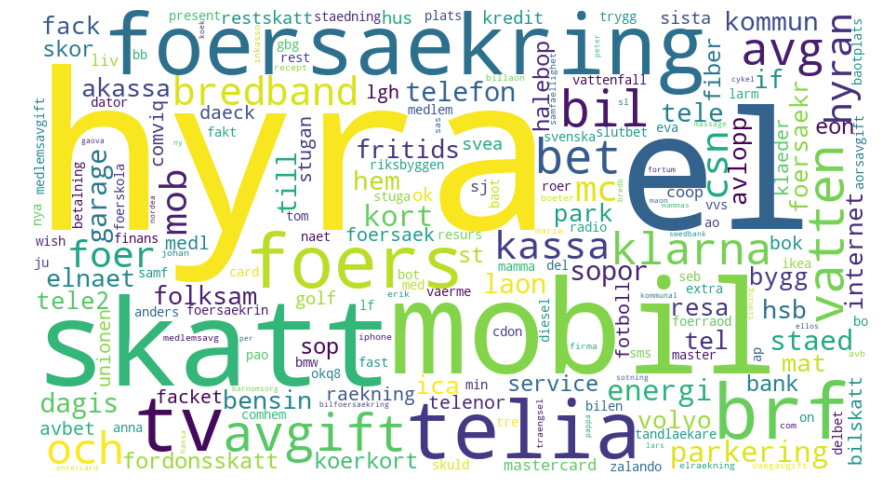

In [42]:
wordcloudpic2(inputdata=debt_pgbg_clean, inputCol="transactioninfo_cleaned")

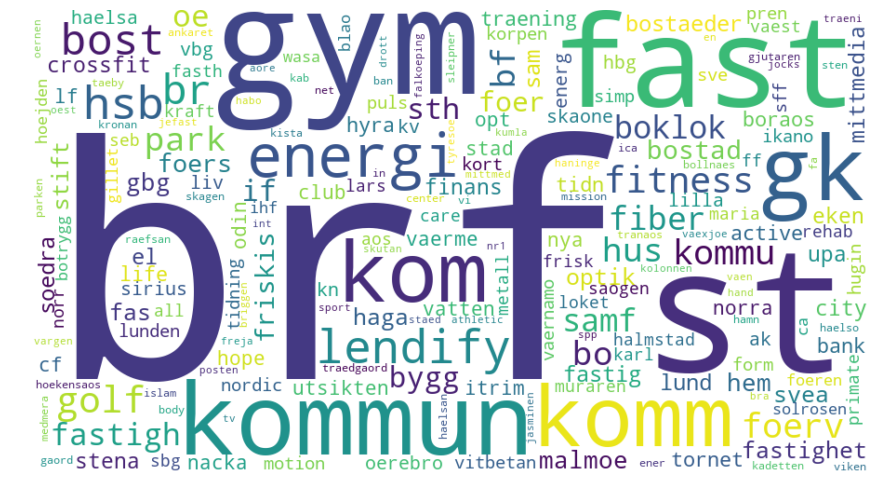

In [43]:
wordcloudpic2(inputdata=debt_autogiro_clean, inputCol="transactioninfo_cleaned")

### <font color='blue'>2.2.2 Levenshtein Comparison</font>
#### <font color='blue'>We want to identify which autogiro payments that are used to pay for debt</font>
Compare single words in the names of the financial institutions between debt_autogiro and loan_provider. We compare this result to the model results

#### <font color='blue'>Create list of words from names in autogiro transactioninfo_cleaned</font>

In [112]:
# Create column with list of all words that make up the name of the financial institute.     
regexTokenizer = RegexTokenizer(inputCol="transactioninfo_cleaned", outputCol="words", minTokenLength=2, pattern=("\\W"))
stopwordsRemover=StopWordsRemover(inputCol="words",outputCol="filtered").setStopWords(add_words)
debt_autogiro_levenshtein=stopwordsRemover.transform((regexTokenizer.transform(debt_autogiro_clean).dropDuplicates()
                             .withColumn('dataset', F.lit('autogiro'))
                             .filter((F.col('words').getItem(0).isNotNull()))
                            )).drop(F.col('words')).withColumnRenamed('filtered','words')\
                              .filter(F.col('words').getItem(0).isNotNull())

debt_autogiro_levenshtein.sort('words').show(5, False)

#-----------------------------------------------------------------------------
# list of only words in names in external loan providers list (ignore numerical values)
# change names of columns so that we can union autogiro df and loanprovider df
regexTokenizer = RegexTokenizer(inputCol="provider_cleaned", outputCol="words_provider", minTokenLength=2, pattern=("\\W"))
loanproviders_levenshtein = (regexTokenizer.transform(banklist_clean).dropDuplicates()
                             .withColumn('dataset', F.lit('loanprovider')))
loanproviders_levenshtein.show(2, False)

+---------------+---------+---------+------------+-----------------------+--------+----------------+
|transactioninfo|nr_of_trx|vol      |ID          |transactioninfo_cleaned|dataset |words           |
+---------------+---------+---------+------------+-----------------------+--------+----------------+
|101NET KÄGLI   |1        |1650.00  |463856469080|101net kaegli          |autogiro|[101net, kaegli]|
|1Hem Fast AB   |47       |325550.00|206158430286|1hem fast ab           |autogiro|[1hem, fast]    |
|24Storage      |323      |286167.00|77309411428 |24storage              |autogiro|[24storage]     |
|26an HyrGym    |65       |11541.00 |180388626471|26an hyrgym            |autogiro|[26an, hyrgym]  |
|30K SÖVDE      |76       |19566.00 |163208757360|30k soevde             |autogiro|[30k, soevde]   |
+---------------+---------+---------+------------+-----------------------+--------+----------------+
only showing top 5 rows

+----------+----------------+--------------+------------+
|banklis

#### <font color='blue'> Add Customer Name column with words in alphabetical order</font>
- Explode all split words to create column with words that can be sorted in alphabetical order, to make levenshtein on later on
- aggregate splitwords to get them in alphabetic order

In [113]:
# for autogiro trx
debt_autogiro_levenshtein = debt_autogiro_levenshtein.withColumn('single_word', F.explode(F.col('words')))\
    .sort(F.asc('ID'),F.asc('transactioninfo_cleaned'),F.asc('single_word'))\
    .groupBy('ID'\
             ,'transactioninfo'\
             ,'transactioninfo_cleaned'\
             ,'dataset')\
    .agg(F.concat_ws(" ", F.collect_list('single_word')).alias('trxinfo_text_sorted')).sort(F.asc('trxinfo_text_sorted'))
        
debt_autogiro_levenshtein.show(4)
#-----------------------------------------------------------------------------
# For loan providers
sel_col = ['provider_cleaned','dataset']
w = Window.partitionBy('provider_cleaned').orderBy('single_word')

loanproviders_levenshtein = (loanproviders_levenshtein.withColumn('single_word', F.explode(F.col('words_provider')))
        .withColumn(
            'provider_cleaned_sorted', F.collect_list('single_word').over(w)
        )
        .groupBy(sel_col)
        .agg(F.max('provider_cleaned_sorted').alias('provider_cleaned_sorted')).sort(F.asc('provider_cleaned'))
        .withColumn('provider_cleaned_sorted',F.concat_ws(" ", 'provider_cleaned_sorted')).sort(F.asc('provider_cleaned')))
        
loanproviders_levenshtein.show(4)

+------------+---------------+-----------------------+--------+-------------------+
|          ID|transactioninfo|transactioninfo_cleaned| dataset|trxinfo_text_sorted|
+------------+---------------+-----------------------+--------+-------------------+
|463856469080|   101NET KÄGLI|          101net kaegli|autogiro|      101net kaegli|
|395136991402|   SOMMARRO 1BF|           sommarro 1bf|autogiro|       1bf sommarro|
|455266533618|   VÄRNHEM 1BRF|          vaernhem 1brf|autogiro|      1brf vaernhem|
|463856468266|   T Lendify 1C|           t lendify 1c|autogiro|         1c lendify|
+------------+---------------+-----------------------+--------+-------------------+
only showing top 4 rows

+----------------+------------+-----------------------+
|provider_cleaned|     dataset|provider_cleaned_sorted|
+----------------+------------+-----------------------+
|        4finance|loanprovider|               4finance|
|     aasa kredit|loanprovider|            aasa kredit|
|          advisa|loanp

#### <font color='blue'> Re-do the words column based on trxinfo_text_sorted and explode into token (single words)</font>

In [114]:
# list of only words in names in external loan providers list (ignore numerical values)
# change names of columns so that we can union autogiro df and loanprovider df

# autogiro
regexTokenizer = RegexTokenizer(inputCol="trxinfo_text_sorted", outputCol="words", minTokenLength=1, pattern=("\\W"))
debt_autogiro_levenshtein = (regexTokenizer.transform(debt_autogiro_levenshtein).dropDuplicates())
                            
sel_col = ['transactioninfo','transactioninfo_cleaned','trxinfo_text_sorted','ID','words']
debt_autogiro_levenshtein = debt_autogiro_levenshtein.select(sel_col).withColumn('tokens',F.explode('words'))
debt_autogiro_levenshtein.show(5, False)

# loan providers
regexTokenizer = RegexTokenizer(inputCol="provider_cleaned_sorted", outputCol="words_provider", minTokenLength=1, pattern=("\\W"))
loanproviders_levenshtein = (regexTokenizer.transform(loanproviders_levenshtein).dropDuplicates())

sel_col = ['provider_cleaned','provider_cleaned_sorted','words_provider']
loanproviders_levenshtein = loanproviders_levenshtein.select(sel_col).withColumn('tokens_provider',F.explode('words_provider'))
loanproviders_levenshtein.show(5, False)

+---------------+-----------------------+-------------------+------------+----------------+--------+
|transactioninfo|transactioninfo_cleaned|trxinfo_text_sorted|ID          |words           |tokens  |
+---------------+-----------------------+-------------------+------------+----------------+--------+
|101NET KÄGLI   |101net kaegli          |101net kaegli      |463856469080|[101net, kaegli]|101net  |
|101NET KÄGLI   |101net kaegli          |101net kaegli      |463856469080|[101net, kaegli]|kaegli  |
|SOMMARRO 1BF   |sommarro 1bf           |1bf sommarro       |395136991402|[1bf, sommarro] |1bf     |
|SOMMARRO 1BF   |sommarro 1bf           |1bf sommarro       |395136991402|[1bf, sommarro] |sommarro|
|VÄRNHEM 1BRF   |vaernhem 1brf          |1brf vaernhem      |455266533618|[1brf, vaernhem]|1brf    |
+---------------+-----------------------+-------------------+------------+----------------+--------+
only showing top 5 rows

+----------------+-----------------------+--------------+---------

#### <font color='blue'> Levenshtein comparison</font>
- if a word is one or two letters, LD = 0
- if a word is three or four letters, LD <=1
- if a word is five or more letters, LD <= 2

In [115]:
# do a levenshtein comparison

df1 = debt_autogiro_levenshtein
df2 = loanproviders_levenshtein

levenshtein1 = (levenshtein(df1['tokens'], df2['tokens_provider']) < 1)
levenshtein2 = (levenshtein(df1['tokens'], df2['tokens_provider']) < 2)
levenshtein3 = (levenshtein(df1['tokens'], df2['tokens_provider']) < 3)

join_condition = ((F.when(F.length(df1['tokens']) <= 2, levenshtein1)) |
                (F.when(F.length(df1['tokens']) == 3, levenshtein2)) |
                (F.when(F.length(df1['tokens']) == 4, levenshtein2)) |
                (F.when(F.length(df1['tokens']) > 4, levenshtein3)))

df_levenshtein = (df1.join(df2, join_condition)
    .withColumn('levenshtein', levenshtein(df1['tokens'], df2['tokens_provider']))    
)
df_levenshtein.show(3)
print(df_levenshtein.count())

+---------------+-----------------------+-------------------+------------+-------------+-------+----------------+-----------------------+--------------+---------------+-----------+
|transactioninfo|transactioninfo_cleaned|trxinfo_text_sorted|          ID|        words| tokens|provider_cleaned|provider_cleaned_sorted|words_provider|tokens_provider|levenshtein|
+---------------+-----------------------+-------------------+------------+-------------+-------+----------------+-----------------------+--------------+---------------+-----------+
|     JI Finance|             ji finance|         finance ji|197568495695|[finance, ji]|finance|        4finance|               4finance|    [4finance]|       4finance|          1|
|       Qasa AB3|               qasa ab3|           ab3 qasa|377957122151|  [ab3, qasa]|   qasa|     aasa kredit|            aasa kredit|[aasa, kredit]|           aasa|          1|
|           Änsa|                  aensa|              aensa|231928234086|      [aensa]|  aensa

#### <font color='blue'>Print Levensthein output to csv file</font>

In [116]:
# Autogiro debt result from LD comparison with loan provder list
sel_col = ['provider_cleaned','transactioninfo','levenshtein']
pandaoutput = (df_levenshtein
                .select(sel_col)
                .sort('levenshtein').dropDuplicates()
                .toPandas())

pandaoutput.to_csv(os.path.join('~/repos', 'autogiro_provider_levenshtein' + '.csv'), encoding='utf-8')

#### <font color='blue'>Subset of exact matches on full names</font>
We start by definint a subset where the external loan provider name is part of the transactioninfo field

In [117]:
# banklist = list of financial institutions

(df_levenshtein
     .filter(F.col('transactioninfo_cleaned')
             .rlike('(^|\s)(' + '|'.join(banklist) + ')(\s|$|\s\w+)'))
).select('transactioninfo').dropDuplicates().sort(F.desc('transactioninfo')).show(500, False)

+---------------+
|transactioninfo|
+---------------+
|gjensidige     |
|VOLVOFINANS    |
|VOLVO FINANS   |
|TSS FINANS     |
|T Lendify nj   |
|T Lendify nf   |
|T Lendify nd   |
|T Lendify n6   |
|T Lendify n5   |
|T Lendify md   |
|T Lendify mb   |
|T Lendify ma   |
|T Lendify m1   |
|T Lendify l5   |
|T Lendify l3   |
|T Lendify em   |
|T Lendify e2   |
|T Lendify dm   |
|T Lendify dh   |
|T Lendify dc   |
|T Lendify d1   |
|T Lendify cc   |
|T Lendify c9   |
|T Lendify c8   |
|T Lendify c7   |
|T Lendify c5   |
|T Lendify c2   |
|T Lendify bn   |
|T Lendify bk   |
|T Lendify ba   |
|T Lendify bH   |
|T Lendify bE   |
|T Lendify b2   |
|T Lendify 4m   |
|T Lendify 4l   |
|T Lendify 4B   |
|T Lendify 41   |
|T Lendify 3s   |
|T Lendify 3r   |
|T Lendify 3j   |
|T Lendify 3H   |
|T Lendify 3E   |
|T Lendify 2m   |
|T Lendify 2k   |
|T Lendify 2g   |
|T Lendify 2d   |
|T Lendify 2c   |
|T Lendify 2b   |
|T Lendify 2H   |
|T Lendify 23   |
|T Lendify 1q   |
|T Lendify 1d   |
|T Lendify

In [118]:
(df_levenshtein
     .filter(F.col('transactioninfo_cleaned')
             .rlike('(^|\s)(' + '|'.join(banklist) + ')(\s|$|\s\w+)'))
).select('transactioninfo').dropDuplicates().count()

173

In [120]:
# CC: subset of the exact matches.
autogiro_provider_levenshtein_subset=(df_levenshtein
     .filter(F.col('transactioninfo_cleaned')
             .rlike('(^|\s)(' + '|'.join(banklist) + ')(\s|$|\s\w+)')).select('transactioninfo').dropDuplicates())
autogiro_provider_levenshtein_subset.count()
autogiro_provider_levenshtein_subset.show(150)

sel_col = ['provider_cleaned','transactioninfo','levenshtein']
pandaoutput = autogiro_provider_levenshtein_subset.toPandas()
pandaoutput.to_csv(os.path.join('~/repos', 'autogiro_provider_levenshtein_subset' + '.csv'), encoding='utf-8')

+---------------+
|transactioninfo|
+---------------+
|      ENTERCARD|
|      SANTANDER|
|   T Lendify 1d|
|        Credigo|
|   GOTHIA GROUP|
|     NORDEA LIV|
|     Resurs Ban|
|        LF LARM|
|     DNB Fonder|
|     AVANZA BAN|
|   T Lendify cc|
|   T Lendify 16|
|   T Lendify n5|
|       LF MOTOR|
|   MEDMERA VISA|
|   T Lendify 14|
|     MARGINALEN|
|   SVEA INKASSO|
|   T Lendify 3j|
|   T Lendify c5|
|   T Lendify l5|
|     ICA BANKEN|
|   T Lendify 2b|
|   T Lendify e2|
|   VOLVO FINANS|
|       Balanzia|
|       Bluestep|
|   T Lendify 3s|
|   INTRUM JUSTI|
|             LF|
|   T Lendify 3H|
|   T Lendify mb|
|   SVEA EKONOMI|
|   Avida Finans|
|   T Lendify 4l|
|   DANSKE FINAN|
|            SEB|
|   LANDSHYPOTEK|
|   T Lendify c2|
|     Ok Q8 Bank|
|   ICA FÖRLAGET|
|         LF LIV|
|   NB FINANS AB|
|   NORDNET FÖRS|
|   IKANO Bostad|
|    Folkefinans|
|   Svea Ekonomi|
|       BLUESTEP|
|   Ikano Bostad|
|      CASHBUDDY|
|       Afterpay|
|   T Lendify 2k|
|     TSS 

## <font color='blue'> 2.3 Processing data sets and building pipelines </font>

### <font color='blue'> 2.3.1 further data exploration to remove outliers (transactioninfo used too rare) </font> 

+-------------+----------------+---------+------------+----------+---------+----------------+---+-----------------------+
|secaccountnum|transactioninfo |nr_of_trx|vol         |category  |provider |provider_cleaned|ID |transactioninfo_cleaned|
+-------------+----------------+---------+------------+----------+---------+----------------+---+-----------------------+
|41585027     |KLARNA AB /NORDE|526300   |369275848.28|invoice   |klarna   |klarna          |0  |klarna ab norde        |
|8200040      |TELIASONERA SVER|383497   |217271241.43|null      |null     |null            |1  |teliasonera sver       |
|51225860     |ENTERCARD SVERIG|239163   |725503638.68|creditcard|entercard|entercard       |2  |entercard sverig       |
|53311338     |Telenor Sverige |191901   |128281567.53|null      |null     |null            |3  |telenor sverige        |
|9366006      |Tele2 - Mobila t|164884   |72841935.53 |null      |null     |null            |4  |tele2 mobila t         |
+-------------+---------

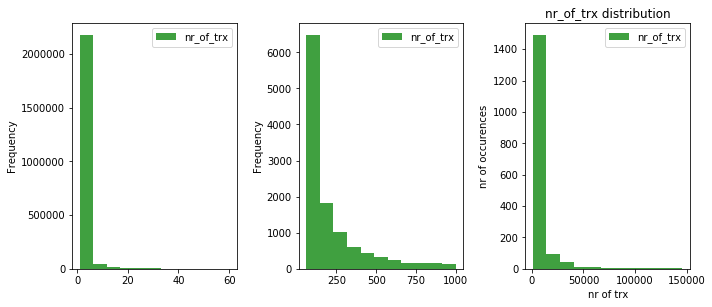

2273204
11525
1691


In [155]:
threshold1=60
threshold2=1000
threshold3=150000

debt_pgbg_clean.sort(F.desc('nr_of_trx')).show(5, False)
#-----------------------------------------------------------------------------
# histogram of the data
pgbg_pd = debt_pgbg_clean.select('nr_of_trx')\
        .withColumn("nr_of_trx", F.col("nr_of_trx").cast("bigint")).toPandas()
plt.clf
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,4))
pgbg_pd[(pgbg_pd.nr_of_trx>0) & (pgbg_pd.nr_of_trx<=threshold1)]\
        .plot.hist(bins=11, facecolor='g', alpha=0.75,ax=ax1)
pgbg_pd[(pgbg_pd.nr_of_trx>threshold1) & (pgbg_pd.nr_of_trx<=threshold2)]\
        .plot.hist(bins=11, facecolor='g', alpha=0.75,ax=ax2)
pgbg_pd[(pgbg_pd.nr_of_trx>threshold2) & (pgbg_pd.nr_of_trx<threshold3)]\
        .plot.hist(bins=11, facecolor='g', alpha=0.75,ax=ax3)
plt.tight_layout()
plt.ylabel('nr of occurences')
plt.xlabel('nr of trx')
plt.title('nr_of_trx distribution')
plt.show()
#----------------------------------------------------------------
print(debt_pgbg_clean.filter(F.col('nr_of_trx')<=threshold1).count())
print(debt_pgbg_clean.filter((F.col('nr_of_trx')>threshold1)&(F.col('nr_of_trx')<=threshold2)).count())
print(debt_pgbg_clean.filter(F.col('nr_of_trx')>threshold2).count())

+---------------+---------+------------+---+-----------------------+
|transactioninfo|nr_of_trx|vol         |ID |transactioninfo_cleaned|
+---------------+---------+------------+---+-----------------------+
|Klarna         |1510243  |792424028.13|0  |klarna                 |
|FOLKSAM        |1017746  |595943839.91|1  |folksam                |
|SWEDB FÖRSÄK   |622162   |70343203.00 |2  |swedb foersaek         |
|POSTKODFÖR     |476091   |126282634.78|3  |postkodfoer            |
|LF MOTOR       |395954   |128294570.00|4  |lf motor               |
+---------------+---------+------------+---+-----------------------+
only showing top 5 rows



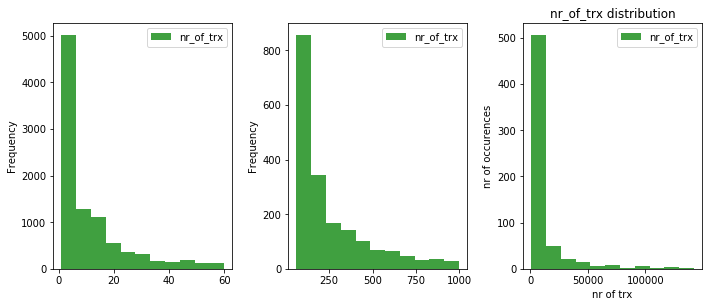

9409
1890
643


In [156]:
debt_autogiro_clean.sort(F.desc('nr_of_trx')).show(5, False)
#--------------------------------------------------------------------
# histogram of the data
autogiro_pd = debt_autogiro_clean.select('nr_of_trx')\
        .withColumn("nr_of_trx", F.col("nr_of_trx").cast("bigint")).toPandas()
plt.clf
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,4))
autogiro_pd[(autogiro_pd.nr_of_trx>0) & (autogiro_pd.nr_of_trx<=threshold1)]\
        .plot.hist(bins=11, facecolor='g', alpha=0.75,ax=ax1)
autogiro_pd[(autogiro_pd.nr_of_trx>threshold1) & (autogiro_pd.nr_of_trx<=threshold2)]\
        .plot.hist(bins=11, facecolor='g', alpha=0.75,ax=ax2)
autogiro_pd[(autogiro_pd.nr_of_trx>threshold2) & (autogiro_pd.nr_of_trx<threshold3)]\
        .plot.hist(bins=11, facecolor='g', alpha=0.75,ax=ax3)
plt.tight_layout()
plt.ylabel('nr of occurences')
plt.xlabel('nr of trx')
plt.title('nr_of_trx distribution')
plt.show()
#------------------------------------------------------------------------
print(debt_autogiro_clean.filter(F.col('nr_of_trx')<=threshold1).count())
print(debt_autogiro_clean.filter((F.col('nr_of_trx')>threshold1)&(F.col('nr_of_trx')<=threshold2)).count())
print(debt_autogiro_clean.filter(F.col('nr_of_trx')>threshold2).count())

### <font color='blue'> 2.3.2 preprocessing data </font> 

#### <font color='blue'>prepare the raw data</font>

In [157]:
# CC: trainraw should be debt_bgpg_clean and the target variable is created through merge the debt_bgpg_clean file 
# CC: with the generated loan provider file through the data set 
#trainraw = bgpg_loanproviders.select('ID','transactioninfo_cleaned','provider','nr_of_trx')\
trainraw = debt_pgbg_clean.select('ID','transactioninfo_cleaned','provider','nr_of_trx').filter(F.col('nr_of_trx')>threshold1)\
            .withColumn('target', F.when(F.col('provider').isNull(), 0).otherwise(1))
trainraw.show(3, False)
# CC: this is how the trainraw should look like
trainraw.groupby('target').count().show()
#-------------------------------------------------------------------
testraw = debt_autogiro_clean.select('ID','transactioninfo_cleaned','nr_of_trx').filter(F.col('nr_of_trx')>threshold1)\
         .withColumn('target', F.lit(0))
testraw.show(3, False)
#-------------------------------------------------------------------
fulldata = trainraw.select('transactioninfo_cleaned','ID','target')\
            .withColumn('data',F.lit('train'))\
            .union(testraw.select('transactioninfo_cleaned','ID','target')\
            .withColumn('data',F.lit('test')))
fulldata.show(5)

# target = 0 when financial institute is known
# target = 1 when financial institute is not known 
# CC: target=1 paying to a financial institution
# CC: target=0 not paying to a financial institution

+---+-----------------------+---------+---------+------+
|ID |transactioninfo_cleaned|provider |nr_of_trx|target|
+---+-----------------------+---------+---------+------+
|0  |klarna ab norde        |klarna   |526300   |1     |
|1  |teliasonera sver       |null     |383497   |0     |
|2  |entercard sverig       |entercard|239163   |1     |
+---+-----------------------+---------+---------+------+
only showing top 3 rows

+------+-----+
|target|count|
+------+-----+
|     1| 2972|
|     0|10244|
+------+-----+

+---+-----------------------+---------+------+
|ID |transactioninfo_cleaned|nr_of_trx|target|
+---+-----------------------+---------+------+
|0  |klarna                 |1510243  |0     |
|1  |folksam                |1017746  |0     |
|2  |swedb foersaek         |622162   |0     |
+---+-----------------------+---------+------+
only showing top 3 rows

+-----------------------+---+------+-----+
|transactioninfo_cleaned| ID|target| data|
+-----------------------+---+------+-----+
| 

#### <font color='blue'>Build pipeline</font>

In [158]:
# maybe define recurring payments to narrow down the training dataset.
# stop words (from nltk.corpus import stopwords) and same meaning words (porter stemming and lemmatizing)
# https://wesslen.github.io/twitter/predicting_twitter_profile_location_with_pyspark/
# https://towardsdatascience.com/multi-class-text-classification-with-pyspark-7d78d022ed35
# https://www.kaggle.com/thibaultgiordan/text-mining-with-spark

In [159]:
#use regextokenizer, space separates tokens
regexTokenizer = RegexTokenizer(inputCol="transactioninfo_cleaned", outputCol="words", minTokenLength=2, pattern=("\\W"))

#test regextokenizer
countTokens=F.udf(lambda words: len(words), IntegerType())
regexTokenized = regexTokenizer.transform(trainraw)
regexTokenized.select("transactioninfo_cleaned", "words") \
    .withColumn("tokens", countTokens(F.col("words"))).show(truncate=False)
regexTokenized.show(5)

+-----------------------+--------------------+------+
|transactioninfo_cleaned|words               |tokens|
+-----------------------+--------------------+------+
|klarna ab norde        |[klarna, ab, norde] |3     |
|teliasonera sver       |[teliasonera, sver] |2     |
|entercard sverig       |[entercard, sverig] |2     |
|telenor sverige        |[telenor, sverige]  |2     |
|tele2 mobila t         |[tele2, mobila]     |2     |
|fordonsskatt tra       |[fordonsskatt, tra] |2     |
|radiotjaenst i ki      |[radiotjaenst, ki]  |2     |
|telia                  |[telia]             |1     |
|radiotjaenst i ki      |[radiotjaenst, ki]  |2     |
|telia mobil mobi       |[telia, mobil, mobi]|3     |
|halebop                |[halebop]           |1     |
|entercard och pa       |[entercard, och, pa]|3     |
|resurs bank ab         |[resurs, bank, ab]  |3     |
|hi3g access ab         |[hi3g, access, ab]  |3     |
|3 hi3g access a        |[hi3g, access]      |2     |
|unionens arbetsl       |[un

In [160]:
# remove stopwords
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_words)

#test stopwordsremover
stopwordscleaned=stopwordsRemover.transform(regexTokenized)
stopwordscleaned.show(5)

+---+-----------------------+---------+---------+------+-------------------+-------------------+
| ID|transactioninfo_cleaned| provider|nr_of_trx|target|              words|           filtered|
+---+-----------------------+---------+---------+------+-------------------+-------------------+
|  0|        klarna ab norde|   klarna|   526300|     1|[klarna, ab, norde]|    [klarna, norde]|
|  1|       teliasonera sver|     null|   383497|     0|[teliasonera, sver]|[teliasonera, sver]|
|  2|       entercard sverig|entercard|   239163|     1|[entercard, sverig]|        [entercard]|
|  3|        telenor sverige|     null|   191901|     0| [telenor, sverige]|          [telenor]|
|  4|         tele2 mobila t|     null|   164884|     0|    [tele2, mobila]|    [tele2, mobila]|
+---+-----------------------+---------+---------+------+-------------------+-------------------+
only showing top 5 rows



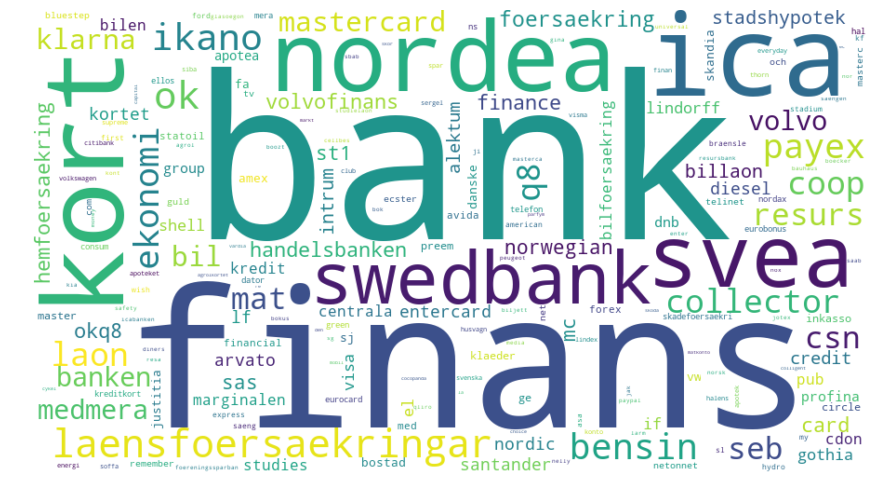

In [161]:
# Visualize all words in training dataset when target = 1 (i.e. trxinfo matched to loan provider) 
# CC: before remove stop words
from wordcloud import WordCloud
words = (stopwordscleaned.filter(F.col('target')==1)
         .select(F.posexplode('filtered').alias('l1','filtered'))
        .drop('l1').groupby('filtered')
         .agg(F.count('filtered').astype('float').alias('counts'))
         .orderBy(F.desc('counts')).toPandas())

d={}
for a, x in words.values:
    d[a]=int(x)
    
#wordcloud=WordCloud()
wordcloud = WordCloud(
    width = 900,
    height = 500,
    background_color = 'white').generate_from_frequencies(frequencies=d)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [162]:
#use countvectorizer instead. minDF: minimum number of documents a term must appear in order to be included in the vocabulary
#convert a collection of text documents to vectors of token counts
#CountVectorizer will select the top vocabSize words ordered by term frequency across the corpus
cv = CountVectorizer(inputCol="filtered", outputCol="rawFeatures",minDF=1.0) 
#test cv
model = cv.fit(stopwordscleaned)
featurizedData = model.transform(stopwordscleaned)
featurizedData.show(5,truncate=False)
#should remove the records that didn't end up with any feature
featurizedData = featurizedData.filter(~F.col('words').getItem(0).isNull())
featurizedData.show(5,truncate=False)

+---+-----------------------+---------+---------+------+-------------------+-------------------+--------------------------+
|ID |transactioninfo_cleaned|provider |nr_of_trx|target|words              |filtered           |rawFeatures               |
+---+-----------------------+---------+---------+------+-------------------+-------------------+--------------------------+
|0  |klarna ab norde        |klarna   |526300   |1     |[klarna, ab, norde]|[klarna, norde]    |(5755,[70,724],[1.0,1.0]) |
|1  |teliasonera sver       |null     |383497   |0     |[teliasonera, sver]|[teliasonera, sver]|(5755,[217,311],[1.0,1.0])|
|2  |entercard sverig       |entercard|239163   |1     |[entercard, sverig]|[entercard]        |(5755,[166],[1.0])        |
|3  |telenor sverige        |null     |191901   |0     |[telenor, sverige] |[telenor]          |(5755,[175],[1.0])        |
|4  |tele2 mobila t         |null     |164884   |0     |[tele2, mobila]    |[tele2, mobila]    |(5755,[62,4584],[1.0,1.0])|
+---+---

In [163]:
# Intuitively, idf down-weights columns which appear frequently in a corpus
idf=IDF(inputCol="rawFeatures", outputCol="features_pre")
idfModel=idf.fit(featurizedData)
rescaledData=idfModel.transform(featurizedData)
rescaledData.show(5,truncate=False)

+---+-----------------------+---------+---------+------+-------------------+-------------------+--------------------------+------------------------------------------------------+
|ID |transactioninfo_cleaned|provider |nr_of_trx|target|words              |filtered           |rawFeatures               |features_pre                                          |
+---+-----------------------+---------+---------+------+-------------------+-------------------+--------------------------+------------------------------------------------------+
|0  |klarna ab norde        |klarna   |526300   |1     |[klarna, ab, norde]|[klarna, norde]    |(5755,[70,724],[1.0,1.0]) |(5755,[70,724],[5.990403378206764,7.6951514704451895])|
|1  |teliasonera sver       |null     |383497   |0     |[teliasonera, sver]|[teliasonera, sver]|(5755,[217,311],[1.0,1.0])|(5755,[217,311],[6.847853610057986,7.089015666874874])|
|2  |entercard sverig       |entercard|239163   |1     |[entercard, sverig]|[entercard]        |(5755,[16

In [164]:
# Learn a mapping from words to Vectors.
# use wordsData from cell 27
word2Vec = Word2Vec(vectorSize=2, minCount=0, inputCol="filtered", outputCol="result")
#test word2vec
model = word2Vec.fit(rescaledData)
result = model.transform(rescaledData)
result.filter(F.col('filtered').getItem(0).isNotNull()).orderBy(F.col('filtered').getItem(0), F.desc('result')).show(5)

+----------+-----------------------+--------+---------+------+-------------------+-------------+--------------------+--------------------+--------------------+
|        ID|transactioninfo_cleaned|provider|nr_of_trx|target|              words|     filtered|         rawFeatures|        features_pre|              result|
+----------+-----------------------+--------+---------+------+-------------------+-------------+--------------------+--------------------+--------------------+
|     11952|               101ideer|    null|       68|     0|         [101ideer]|   [101ideer]| (5755,[4755],[1.0])|(5755,[4755],[8.7...|[0.22869935631752...|
|     11954|                   24mx|  klarna|       68|     1|             x]|       x]| (5755,[2620],[1.0])|(5755,[2620],[8.7...|[-0.2065825164318...|
|      4019|       24storage sverig|    null|      304|     0|[24storage, sverig]|  [24storage]| (5755,[4356],[1.0])|(5755,[4356],[8.7...|[0.02510428428649...|
|     11875|          3b kapital ab|    null|   

In [165]:
#put features together

assembler = VectorAssembler( inputCols=['rawFeatures'], outputCol='features')

assembled=assembler.transform(result)
assembled.select('features').show(5, False)

+--------------------------+
|features                  |
+--------------------------+
|(5755,[70,724],[1.0,1.0]) |
|(5755,[217,311],[1.0,1.0])|
|(5755,[166],[1.0])        |
|(5755,[175],[1.0])        |
|(5755,[62,4584],[1.0,1.0])|
+--------------------------+
only showing top 5 rows



### <font color='blue'> 2.3.3 implement the pipeline and build model </font> 
- fit the pipeline on the train data set, which is based on BGPG payments
- apply the pipeline on the fulldata set, which is both train (BGPG) and test (autogiro) data

In [166]:
# all of the data preprocessing steps could be put into a pipeline
from pyspark.ml import Pipeline
pipeline=Pipeline(stages=[regexTokenizer, stopwordsRemover, cv, idf, word2Vec,assembler])

# use train data set to create pipeline
pipelineFit=pipeline.fit(trainraw)

# apply pipeline on fulldata set
processeddata=pipelineFit.transform(fulldata)

# test 
processeddata.show(5)

+-----------------------+---+------+-----+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|transactioninfo_cleaned| ID|target| data|              words|           filtered|         rawFeatures|        features_pre|              result|            features|
+-----------------------+---+------+-----+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|        klarna ab norde|  0|     1|train|[klarna, ab, norde]|    [klarna, norde]|(5755,[68,723],[1...|(5755,[68,723],[5...|[-0.0832718955352...|(5755,[68,723],[1...|
|       teliasonera sver|  1|     0|train|[teliasonera, sver]|[teliasonera, sver]|(5755,[221,308],[...|(5755,[221,308],[...|[0.12405946291983...|(5755,[221,308],[...|
|       entercard sverig|  2|     1|train|[entercard, sverig]|        [entercard]|  (5755,[163],[1.0])|(5755,[163],[6.59...|[0.01518585812300...|  (5755,[163],[1.0])

In [167]:
# create train data set of the processed data
train = (processeddata
        .filter((F.col('words').getItem(0).isNotNull()) & (F.col('data')=='train'))
        .select('ID','target','features')
        .withColumnRenamed('target','label') )

train.show(5, truncate=False)
print(train.count())
train.groupby('label').count().show()

+---+-----+--------------------------+
|ID |label|features                  |
+---+-----+--------------------------+
|0  |1    |(5755,[68,723],[1.0,1.0]) |
|1  |0    |(5755,[221,308],[1.0,1.0])|
|2  |1    |(5755,[163],[1.0])        |
|3  |0    |(5755,[170],[1.0])        |
|4  |0    |(5755,[61,4875],[1.0,1.0])|
+---+-----+--------------------------+
only showing top 5 rows

13185
+-----+-----+
|label|count|
+-----+-----+
|    1| 2960|
|    0|10225|
+-----+-----+



#### <font color='blue'>Model building</font>

##### <font color='blue'>Split the training set into two</font>

In [168]:
seed=111
(traindevdf, traindf) = train.randomSplit(weights=(0.20,0.80),seed=seed) # <> 30 70
print("trainingdev dataset count:"+str(traindevdf.count()),"training dataset count:"+str(traindf.count()))
traindf.groupby('label').count().show()
traindf.show(5, False)
traindevdf.groupby('label').count().show()
traindevdf.show(5,False)

('trainingdev dataset count:2635', 'training dataset count:10550')
+-----+-----+
|label|count|
+-----+-----+
|    1| 2375|
|    0| 8175|
+-----+-----+

+---+-----+---------------------------+
|ID |label|features                   |
+---+-----+---------------------------+
|0  |1    |(5755,[68,723],[1.0,1.0])  |
|2  |1    |(5755,[163],[1.0])         |
|4  |0    |(5755,[61,4875],[1.0,1.0]) |
|5  |0    |(5755,[362,1088],[1.0,1.0])|
|6  |0    |(5755,[143,513],[1.0,1.0]) |
+---+-----+---------------------------+
only showing top 5 rows

+-----+-----+
|label|count|
+-----+-----+
|    1|  585|
|    0| 2050|
+-----+-----+

+---+-----+--------------------------+
|ID |label|features                  |
+---+-----+--------------------------+
|1  |0    |(5755,[221,308],[1.0,1.0])|
|3  |0    |(5755,[170],[1.0])        |
|15 |0    |(5755,[536,541],[1.0,1.0])|
|18 |1    |(5755,[10,27],[1.0,1.0])  |
|23 |1    |(5755,[133,185],[1.0,1.0])|
+---+-----+--------------------------+
only showing top 5 rows



#####  <font color='blue'>logistic regression</font>

In [169]:
from pyspark.ml.classification import LogisticRegression
lr=LogisticRegression(featuresCol='features',labelCol='label',maxIter=10)
lrModel=lr.fit(traindf)

trainingSummary=lrModel.summary
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

areaUnderROC: 0.996456127475


In [170]:
trainingSummary=lrModel.summary

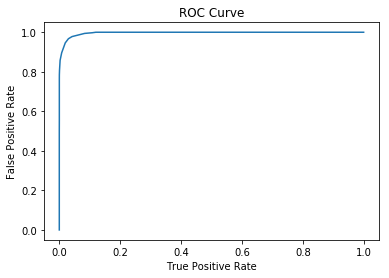

areaUnderROC: 0.996456127475


In [171]:
#ROC
roc=trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

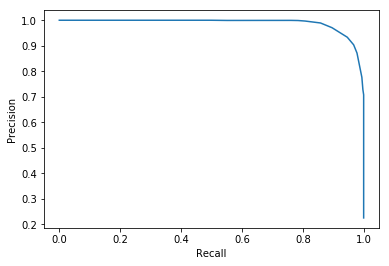

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  154|
|    0|       0.0| 8039|
|    1|       1.0| 2221|
|    0|       1.0|  136|
+-----+----------+-----+

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  108|
|    0|       0.0| 1990|
|    1|       1.0|  477|
|    0|       1.0|   60|
+-----+----------+-----+



In [172]:
#precision and recall
pr=trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#precision=TP/(TP+FP) out of those predicted positive, how many of them are actual positive.
#Precision is a good measure to determine, when the costs of False Positive is high.
#(sensitivity) recall=TP/(TP+FN) how many of the Actual Positives our model capture through labeling it as Positive (True Positive)
#when there is a high cost associated with False Negative

#1% false positive 2% false negative
predictions=lrModel.transform(traindf)
traindf_pred=trainraw.join(predictions,['ID'],'inner')
traindf_pred.groupby('label','prediction').count().show()

#16% false positive 5% false negative
predictions=lrModel.transform(traindevdf)
traindevdf_pred=trainraw.join(predictions,['ID'],'inner')
traindevdf_pred.groupby('label','prediction').count().show()

#####  <font color='blue'>Evaluate model with BinaryClassificationEvaluator</font>

In [173]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

# Evaluate model
predictions=lrModel.transform(traindevdf)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.996456127475
Test: Area Under ROC: 0.967257869502


#####  <font color='blue'>Show all prediction errors</font>

In [174]:
print(result.filter(F.col('filtered').getItem(0).isNotNull())\
      .select('ID','transactioninfo_cleaned','words')\
.join(traindevdf.select('ID','label'),['ID'],'inner')\
.join(predictions.select('ID','probability','prediction'),['ID'],'left')\
      .filter(F.col('label')<>F.col('prediction')).count())

165


In [175]:
result.filter(F.col('filtered').getItem(0).isNotNull())\
    .select('ID','transactioninfo_cleaned','words')\
    .join(traindevdf.select('ID','label'),['ID'],'inner')\
    .join(predictions.select('ID','probability','prediction'),['ID'],'left')\
    .filter(F.col('label')<>F.col('prediction')).show(10, False)

+----+-----------------------+---------------------+-----+-----------------------------------------+----------+
|ID  |transactioninfo_cleaned|words                |label|probability                              |prediction|
+----+-----------------------+---------------------+-----+-----------------------------------------+----------+
|310 |redcats finans a       |[redcats, finans]    |1    |[0.7180091990388143,0.2819908009611857]  |0.0       |
|361 |synoptik sweden        |[synoptik, sweden]   |0    |[0.31818508743189605,0.6818149125681039] |1.0       |
|654 |ikanobank              |[ikanobank]          |1    |[0.8767391932942789,0.12326080670572119] |0.0       |
|690 |preem                  |[preem]              |1    |[0.6411169635572278,0.3588830364427722]  |0.0       |
|718 |statoil                |[statoil]            |1    |[0.5451810771746229,0.45481892282537706] |0.0       |
|828 |circle k               |[circle]             |1    |[0.6214700632130431,0.37852993678695696] |0.0 

#####  <font color='blue'>Evaluate model with crossvalidator</font>

In [176]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(traindf)

predictions = cvModel.transform(traindevdf)
# Evaluate best model
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.970018761726


In [148]:
print('Model Intercept: ', cvModel.bestModel.intercept)

('Model Intercept: ', -1.6159909127546512)


In [149]:
weights = cvModel.bestModel.coefficients
weights = [(float(w),) for w in weights]  # convert numpy type to float, and to tuple
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
display(weightsDF)

DataFrame[Feature Weight: double]

In [150]:
weightsDF.show(5)

+-------------------+
|     Feature Weight|
+-------------------+
|-0.5919930208551708|
|-0.5554549407460532|
| -0.450354419045084|
|-0.8034195193625234|
|-0.5850172853487027|
+-------------------+
only showing top 5 rows



##### <font color='blue'>Test the model on the test data (autogiro data without labels)</font>

In [151]:
test = processeddata.filter((F.col('words').getItem(0).isNotNull()) & (F.col('data')=='test'))\
                    .select('ID','target','features')\
                    .withColumnRenamed('target','label')
test.show(5, truncate=False)
print(test.count())                     

+---+-----+----------------------------+
|ID |label|features                    |
+---+-----+----------------------------+
|0  |0    |(10034,[61],[1.0])          |
|1  |0    |(10034,[64],[1.0])          |
|2  |0    |(10034,[861,1229],[1.0,1.0])|
|3  |0    |(10034,[],[])               |
|4  |0    |(10034,[198,223],[1.0,1.0]) |
+---+-----+----------------------------+
only showing top 5 rows

3429


In [152]:
lr.getThreshold()

0.5

In [153]:
predictions=lrModel.transform(test)
predictions.show(5, False)

+---+-----+----------------------------+----------------------------------------+------------------------------------------+----------+
|ID |label|features                    |rawPrediction                           |probability                               |prediction|
+---+-----+----------------------------+----------------------------------------+------------------------------------------+----------+
|0  |0    |(10034,[61],[1.0])          |[-6.139621392070312,6.139621392070312]  |[0.0021511024271541343,0.9978488975728459]|1.0       |
|1  |0    |(10034,[64],[1.0])          |[6.305778748329063,-6.305778748329063]  |[0.9981776033573776,0.001822396642622319] |0.0       |
|2  |0    |(10034,[861,1229],[1.0,1.0])|[-10.539363343888374,10.539363343888374]|[2.6472878096840984E-5,0.9999735271219032]|1.0       |
|3  |0    |(10034,[],[])               |[2.025768097286494,-2.025768097286494]  |[0.883476126721946,0.11652387327805393]   |0.0       |
|4  |0    |(10034,[198,223],[1.0,1.0]) |[4.96949

In [154]:
check_auto = debt_autogiro_clean.join(predictions,['ID'],'left')
check_auto.groupby('prediction').count().show(5)

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 3161|
|      null| 8513|
|       1.0|  268|
+----------+-----+



In [124]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

firstelement=udf(lambda v:float(v[0]),FloatType())

print(check_auto.filter((F.col('prediction')==1)&(firstelement(F.col('probability'))<=0.5))
        .select('ID','transactioninfo_cleaned','label','probability','prediction')
        .count())

check_auto.filter((F.col('prediction')==1)&(firstelement(F.col('probability'))<=0.5))\
        .select('ID','transactioninfo','transactioninfo_cleaned','label','probability','prediction')\
        .show(250)

287
+------------+---------------+-----------------------+-----+--------------------+----------+
|          ID|transactioninfo|transactioninfo_cleaned|label|         probability|prediction|
+------------+---------------+-----------------------+-----+--------------------+----------+
|           0|         Klarna|                 klarna|    0|[0.00152260400230...|       1.0|
|           2|   SWEDB FÖRSÄK|         swedb foersaek|    0|[7.01091074515980...|       1.0|
|           7|             LF|                     lf|    0|[0.02455195945672...|       1.0|
|           9|   IF SKADEFÖRS|          if skadefoers|    0|[0.25605830369337...|       1.0|
|          13|           SBAB|                   sbab|    0|[0.00110099476503...|       1.0|
|          16|      FITNESS24|              fitness24|    0|[6.99139179034129...|       1.0|
|          22|            CSN|                    csn|    0|[0.02246537417732...|       1.0|
|          26|        SKANDIA|                skandia|    0|[1.546

In [125]:
pandaoutput = check_auto.filter((F.col('prediction')==1)&(firstelement(F.col('probability'))<=0.5))\
        .select('ID','transactioninfo','transactioninfo_cleaned','label','probability','prediction').toPandas()
pandaoutput.to_csv(os.path.join('~/repos', 'autogiro_provider_model' + '.csv'), encoding='utf-8')